In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from seaborn import set_style
import kagglehub
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
set_style("whitegrid")

In [61]:
dst_stocks = pd.read_csv('DST_Finance_Stocks.csv')
weekend_stocks = pd.read_csv('Weekends_Finance_Stocks.csv')
print(len(dst_stocks))
print(len(weekend_stocks))

22807
516370


In [4]:
dst_stocks['return'] = np.square((dst_stocks['mon_close']-dst_stocks['fri_close'])/dst_stocks['fri_close'])
weekend_stocks['return'] = np.square((weekend_stocks['mon_close']-weekend_stocks['fri_close'])/weekend_stocks['fri_close'])
dst_stocks['mon_range'] = dst_stocks['mon_high']-dst_stocks['mon_low']
dst_stocks['fri_range'] = dst_stocks['fri_high']-dst_stocks['fri_low']
weekend_stocks['mon_range'] = weekend_stocks['mon_high']-weekend_stocks['mon_low']
weekend_stocks['fri_range'] = weekend_stocks['fri_high']-weekend_stocks['fri_low']
dst_stocks['y'] = 1
weekend_stocks['y'] = 0
fit_input = pd.DataFrame()
fit_input['X']=pd.concat([dst_stocks['return'],weekend_stocks['return']])
fit_input['y'] = pd.concat([dst_stocks['y'],weekend_stocks['y']])
fit_input = fit_input.sample(frac=1).reset_index()
fit_input

,index,X,y
0,72843,0.000000,0
1,317557,0.000093,0
2,21727,0.000116,1
3,72022,0.000832,0
4,66108,0.000016,0
...,...,...,...
539172,191532,0.000657,0
539173,266845,0.000362,0
539174,154855,0.006854,0
539175,21469,0.000086,0


In [26]:
log_reg = LogisticRegression(penalty=None)
X = fit_input[['X']].values
y = fit_input['y'].values
log_reg.fit(X,y)
print(f'sklearn obtains the fit m = {log_reg.coef_[0][0]} and b = { log_reg.intercept_[0]}')

sklearn obtains the fit m = -0.09660177658697883 and b = -3.08839306529518


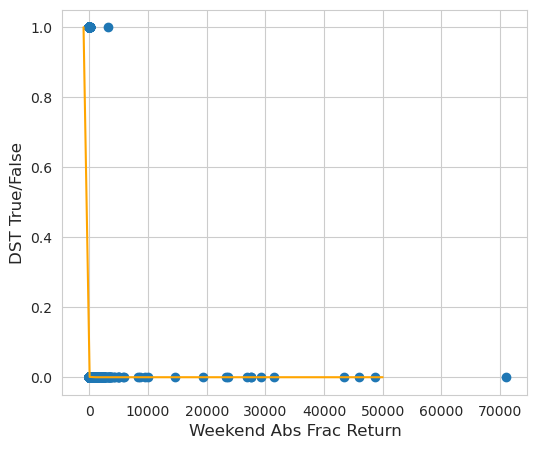

In [29]:
plt.figure(figsize=(6,5))

plt.scatter(X, y)

plt.plot(np.linspace(-1000,50000), log_reg.predict_proba(np.linspace(-1000,50000).reshape(-1,1))[:,1], color = 'orange')
#plt.plot(np.linspace(7,13), my_log_reg.predict_proba(np.linspace(7,13).reshape(-1,1)), c = 'k')

plt.xlabel("Weekend Abs Frac Return", fontsize=12)
plt.ylabel("DST True/False", fontsize=12)
plt.show()

In [29]:
dst_stocks = dst_stocks.sample(frac=1).reset_index()
weekend_stocks = weekend_stocks.sample(frac=1).reset_index()

split80_dst = int(dst_stocks.shape[0]*0.8)-1
split80_wkd = int(weekend_stocks.shape[0]*0.8)-1

dst_train = dst_stocks[:split80_dst]
dst_test = dst_stocks[split80_dst:]
weekend_train = weekend_stocks[:split80_wkd]
weekend_test = weekend_stocks[split80_wkd:]

In [34]:
multivariable_fit_train = pd.DataFrame()
multivariable_fit_train['y'] = pd.concat([dst_train['y'],weekend_train['y']])
multivariable_fit_train['return'] = pd.concat([dst_train['return'],weekend_train['return']])
multivariable_fit_train['mon_volume'] = pd.concat([dst_train['mon_volume'],weekend_train['mon_volume']])
multivariable_fit_train['fri_volume'] = pd.concat([dst_train['fri_volume'],weekend_train['fri_volume']])
multivariable_fit_train['mon_range'] = pd.concat([dst_train['mon_range'],weekend_train['mon_range']])
multivariable_fit_train['fri_range'] = pd.concat([dst_train['fri_range'],weekend_train['fri_range']])
multivariable_fit_train = multivariable_fit_train.sample(frac=1).reset_index()

In [83]:
#X = np.concatenate([multivariable_fit_input[['sq_frac_return']].values,multivariable_fit_input[['mon_volume']].values,multivariable_fit_input[['fri_volume']].values,multivariable_fit_input[['mon_range']].values,multivariable_fit_input[['fri_range']].values],axis=-1)
X = np.concatenate([multivariable_fit_train[['return']].values,multivariable_fit_train[['mon_volume']].values,multivariable_fit_train[['fri_volume']].values,multivariable_fit_train[['mon_range']].values, multivariable_fit_train[['fri_range']].values],axis=-1)
y = multivariable_fit_train['y'].values

In [84]:
model_balanced = LogisticRegression(class_weight='balanced')
model_balanced.fit(X,y)

LogisticRegression(class_weight='balanced')

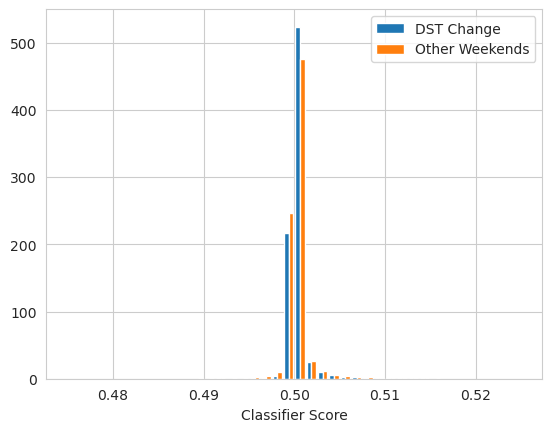

In [89]:
plt.clf()
train_probs_dst = model_balanced.predict_proba(np.concatenate([dst_train[['return']].values,dst_train[['mon_volume']].values,dst_train[['fri_volume']].values,dst_train[['mon_range']].values,dst_train[['fri_range']].values],axis=-1))[:,1]
train_probs_wkd = model_balanced.predict_proba(np.concatenate([weekend_train[['return']].values,weekend_train[['mon_volume']].values,weekend_train[['fri_volume']].values,weekend_train[['mon_range']].values,weekend_train[['fri_range']].values],axis=-1))[:,1]
#test_probs_dst = model_balanced.predict_proba(np.concatenate([dst_test[['return']].values,dst_test[['mon_volume']].values,dst_test[['fri_volume']].values],axis=-1))[:,1]
#test_probs_wkd = model_balanced.predict_proba(np.concatenate([weekend_test[['return']].values,weekend_test[['mon_volume']].values,weekend_test[['fri_volume']].values],axis=-1))[:,1]

plt.hist([train_probs_dst,train_probs_wkd], range=[0.475,0.525], bins=40, density=True, label=['DST Change','Other Weekends'])
plt.legend()
plt.xlabel('Classifier Score')

plt.show()

In [97]:
model_dstHeavy = LogisticRegression(class_weight={0:1,1:30})
model_dstHeavy.fit(X,y)

LogisticRegression(class_weight={0: 1, 1: 30})

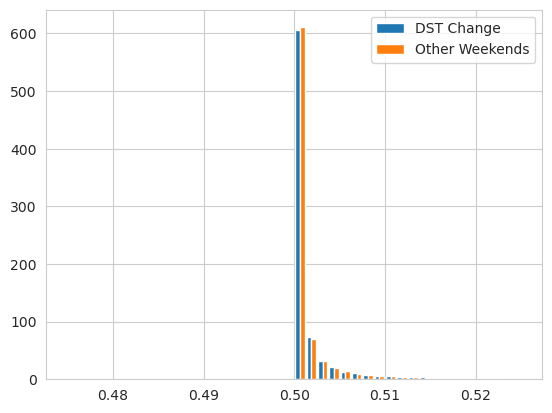

In [98]:
plt.clf()
train_probs_dst = model_dstHeavy.predict_proba(np.concatenate([dst_train[['return']].values,dst_train[['mon_volume']].values,dst_train[['fri_volume']].values,dst_train[['mon_range']].values,dst_train[['fri_range']].values],axis=-1))[:,1]
train_probs_wkd = model_dstHeavy.predict_proba(np.concatenate([weekend_train[['return']].values,weekend_train[['mon_volume']].values,weekend_train[['fri_volume']].values,weekend_train[['mon_range']].values,weekend_train[['fri_range']].values],axis=-1))[:,1]
#test_probs_dst = model_dstHeavy.predict_proba(np.concatenate([dst_test[['return']].values,dst_test[['mon_volume']].values,dst_test[['fri_volume']].values],axis=-1))[:,1]
#test_probs_wkd = model_dstHeavy.predict_proba(np.concatenate([weekend_test[['return']].values,weekend_test[['mon_volume']].values,weekend_test[['fri_volume']].values],axis=-1))[:,1]

plt.hist([train_probs_dst,train_probs_wkd], range=[0.475,0.525], bins=40, density=True, label=['DST Change','Other Weekends'])
plt.legend()

plt.show()

In [48]:
def custom_loss(y,y_pred):
    if y==1:
        loss = (1-y_pred**2)*1000
    else:
        loss = (y_pred)**2
    return loss
custom_loss_scorer = make_scorer(custom_loss, greater_is_better=False)

In [ ]:
plt.clf()
xx, yy = np.mgrid[-1:2:0.01, 0:1000000:10000]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid)[:, 1].reshape(xx.shape)

contour = plt.contourf(xx, yy, probs, 25, alpha = 0.6,
                      vmin=0, vmax=1)
                      
ax_c = plt.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])
plt.xlim([-1,2])

plt.scatter(weekend_stocks['return'],weekend_stocks['mon_volume'])
plt.scatter(dst_stocks['return'],dst_stocks['mon_volume'])
#plt.scatter(X1[:,0],X1[:,1])

plt.show()